In [17]:
from fdfdpy import Simulation

import sys
sys.path.append("..")

from optimization import Optimization
from structures import accelerator

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
# fundamental constants and simulation parameters
lambda_m = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda_m  # angular frequency (2pi/s)
dl = 0.2e-1                   # grid size (L0)
NPML = [15, 0]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 10              # amplitude of modal source (A/L0^2?)

In [132]:
# material constants
n_index = 1.4              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
max_ind_shift = 5.8e-2      # maximum allowed nonlinear refractive index shift (computed from damage threshold)

In [133]:
# geometric parameters
beta = 0.5
gap = 0.4
lambda0 = lambda_m*1e6
L = 2
spc = 2

Computed a domain with 650 grids in x and 50 grids in y
The simulation has 100000000 grids per free space wavelength


/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


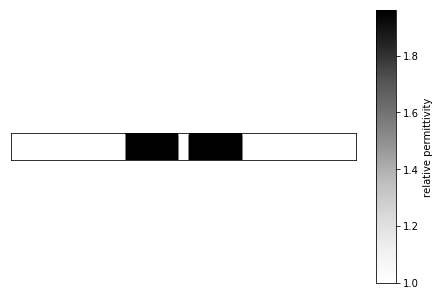

In [134]:
# define permittivity of three port system
eps_r = accelerator(beta, gap, lambda0, L, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega,eps_r,dl,NPML,pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
simulation.plt_eps()
plt.show()

In [135]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.src = np.zeros((Nx, Ny))
simulation.src[NPML[0] + int(spc/dl), :] = 1

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


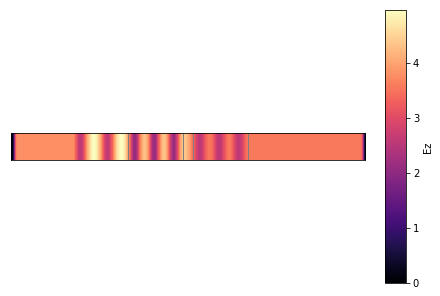

In [136]:
# set source and solve for electromagnetic fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

## Both Linear and Nonlinear

In [137]:
# define linear and nonlinear parts of objective function + the total objective function form
eta = np.zeros((Nx, Ny), dtype=np.complex128)
eta[nx, :] = 1/Ny*np.exp(1j*2*np.pi*dl*np.linspace(0, Ny-1, Ny)/beta/lambda0)
J = {}
J['linear']    = lambda e: np.sum(np.real(e*eta))

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e: eta/2

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
regions = {}
regions['design'] = design_region

In [138]:
# optimization parameters
Nsteps = 500
step_size = 0.01
solver = 'newton'
opt_method = 'adam'

# initialize an optimization object with the above parameters and objective function information
simulation.eps_r = eps_r
optimization = Optimization(Nsteps=Nsteps, J=J, dJdE=dJdE, eps_max=eps_m, step_size=step_size,
                            solver=solver, opt_method=opt_method, max_ind_shift=None)
# optimization.check_deriv_lin(simulation, design_region)

In [139]:
# run the optimization with the simulation and the region and nonlinearity information
new_eps = optimization.run(simulation, regions=regions, nonlin_fns=nonlin_fns)

100% (500 of 500) |######################| Elapsed Time: 0:02:01 ETA:  00:00:00

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


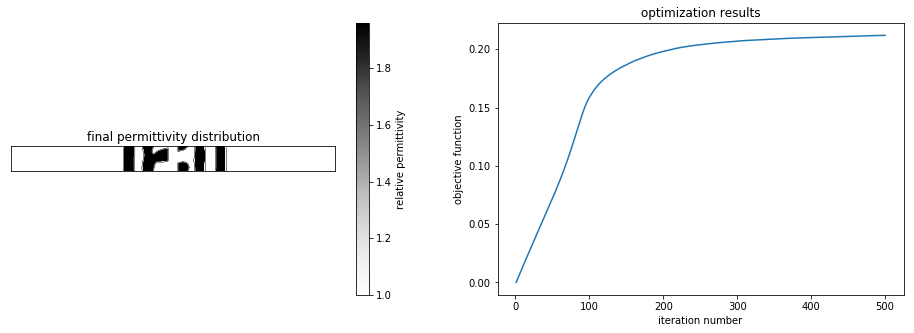

In [140]:
# plot optimization results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

simulation.plt_eps(ax=ax1, tiled_y=5)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


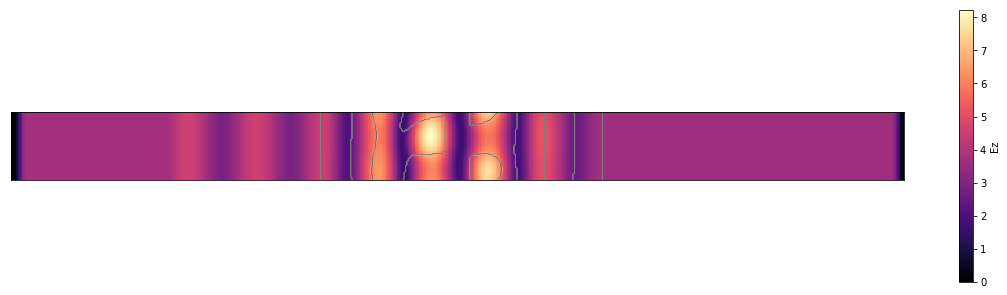

In [142]:
# compare the linear and nonlinear fields

# setup subplots
f, (ax) = plt.subplots(1,1, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax, vmax=None)
ax1.set_title('linear field')

plt.show()